# Machine Vision 2022/23 - Assignment 6: Cross-Validation & SVM

These exercises are made to become familiar with classification techniques of machine learning like support
vector machines and cross-validation.

Your task is to develop a method to classify images of smileys into the two categories, happy smileys and sad smileys.
In the file smileys `res/images_train.npy` you will find a set of training images, while the corresponding labels are stored in `res/labels_train.npy`.

The class label `+1` refers to happy smileys and `−1` to sad smileys.

In [25]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

#### Part 1: Cross-Validation

##### Preparation

(400, 20, 20)
(111, 20, 20)


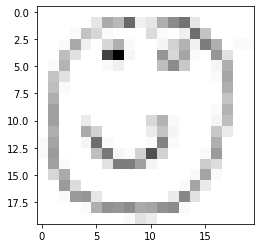

(20, 20)


In [26]:
# @student: load the train/test images and labels
X_train, y_train = np.load("res/images_train.npy"), np.load("res/labels_train.npy")
X_test, y_test = np.load("res/images_test.npy"), np.load("res/labels_test.npy")

# @student: Print the shape of the training and test set. How many training images are in the set, how many test images?
print(X_train.shape)
print(X_test.shape)

# @student: visualize one smiley and print its shape
plt.imshow(X_train[0], cmap="gray")
plt.show()
print(X_train[0].shape)

##### Input Feature Space

In Machine Learning a common task is to engineer the feature space. In our case, the feature space is the full image.
However, not every feature (pixel) may contribute equally while classifying. Hence, your task is to find a feature space that is more suited than the whole picture.

Hint: If you look at the face, which pixels are you looking at in order to classify if the face is happy or sad?

<br></br>
**IMPORTANT: Do not work on this task until you finished this assignment**

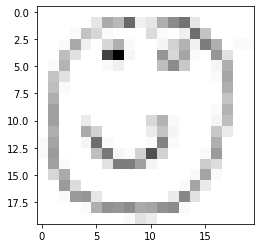

(20, 20)


In [27]:
# IMPORTANT: Do not work on this task until you finished this assignment

def transform_feature_space(*, X):
    # @student: transform input feature space
    X = X[:, 10:16, :]

    return X

X_train = transform_feature_space(X=X_train)
X_test = transform_feature_space(X=X_test)

# @student: visualize one image in the transformed feature space and print its shape
plt.imshow(X_train[0], cmap="gray")
plt.show()
print(X_train[0].shape)

##### Input Data Permutation

Depending on the machine learning algorithm/optimization the order in which the training samples are learned influences the result.
Therefore, it is a good practice to randomly permutate the training data and its labels.

However, you have to make sure to shuffle both data and labels in the same way.

In [28]:
def random_permutation(*, X, y) -> (np.ndarray, np.ndarray):
    assert X.shape[0] == y.shape[0]

    # @student: randomly permutate X, y in the same way
    permutation = np.random.permutation(X.shape[0])
    return X[permutation], y[permutation]

##### K-Folds

In order to use k-fold cross validation, the dataset has to be split into k folds.

In [29]:
def split_k_folds(*, X, y, k) -> (np.ndarray, np.ndarray):
    assert X.shape[0] == y.shape[0], f"X has a different amount of images than labels exist in y (X: {X.shape[0]}, y: {y.shape[0]})"
    assert (X.shape[0] / k).is_integer(), f"The number of images is not evenly divisible by k (X: {X.shape[0]}, k: {k}, X/k = {X.shape[0]/k})"

    # @student: Split X, y in k even folds
    X = np.reshape(X, (k, int(X.shape[0]/k), X.shape[1], X.shape[2]))
    y = np.reshape(y, (k, int(y.shape[0]/k)))

    # Hint: shapes should be: X = [k, num_images/k, u pixels, v pixels], y = [k, num_labels/k]
    return X, y

Depending on the index `i` of the SVM, the train and validation split is determined.

In [30]:
def get_train_and_val_data_for_i(*, X, y, k, i) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    # @student get the train and validation data of the k-folds for the i-th SVM

    # Training Data
    X_train = np.ndarray(shape=[0, X[0].shape[1], X[0].shape[2]])
    y_train = np.ndarray(shape=[0])
    for j in range(k):
        if j == i:
            continue
        X_train = np.concatenate((X_train, X[j]))
        y_train = np.concatenate((y_train, y[j]))

    # Validation Data
    X_val = X[i]
    y_val = y[i]

    return X_train, y_train, X_val, y_val

##### Metrics

In order to decide which SVM performs best, different metrics can be used.
For this task we will use the F1-Score, which is the harmonic mean of precision and recall.

<br></br>
$P = \frac{TP}{TP+FP}$
<br></br>
$R = \frac{TP}{TP+FN}$
<br></br>
$F1 = 2\frac{P*R}{P+R}$

In [31]:
def calculate_f1_score(*, y, y_pred):
    # @student: calculate f1-score
    # hint: the function np.logical_and() may help you

    TP = np.sum(np.logical_and(y_pred==1, y==1))
    FP = np.sum(np.logical_and(y_pred==1, y==-1))
    FN = np.sum(np.logical_and(y_pred==-1, y==1))

    if math.isclose(TP + FP, 0.0):
        P = 0
    else:
        P = TP / (TP + FP)

    if math.isclose(TP + FN, 0.0):
        R = 0
    else:
        R = TP / (TP + FN)

    if math.isclose(P + R, 0.0):
        return 0

    return 2 * (P * R) / (P + R)

##### Input Feature Space

The SVM input is a linear input. Therefore, two-dimensional images have to be transformed into a one dimensional list of pixels

In [32]:
def flatten(*, X, y):
    # @student: reshape the image into a one-dimensional array
    return X.reshape([X.shape[0], -1]), y.flatten()

##### K-Fold Cross Validation

In [33]:
def k_fold_cross_validation(*, X, y, C, sigma, k=4):
    assert X.shape[0] == y.shape[0]

    X, y = random_permutation(X=X, y=y)
    X_split, y_split = split_k_folds(X=X, y=y, k=k)

    # Create k SVM's
    svms = [SVC(C=C, gamma=sigma) for _ in range(k)]

    # Accumulate F1-Score over k-folds
    f1_acc = 0
    # Train and validate on k-folds
    for i in range(k):
        X_train, y_train, X_val, y_val = get_train_and_val_data_for_i(X=X_split, y=y_split, k=k, i=i)

        # Train and Evaluate
        X_train, y_train = flatten(X=X_train, y=y_train)
        X_val, y_val = flatten(X=X_val, y=y_val)
        svms[i].fit(X_train, y_train)
        y_pred = svms[i].predict(X_val)

        f1_acc += calculate_f1_score(y=y_val, y_pred=y_pred)

    # @student: return final f1 score
    return f1_acc / k

##### Execution

An SVM using the RBF kernel has two different hyperparameters: `C` and `sigma`.
You want to optimize these hyperparameters to obtain the highest F1-Score.

To achieve this, different methods exist. You could perform a brute-force grid search, in which
you train and evaluate an SVM with all possible combinations of C and sigma.

In [34]:
# @student: create space over possible C values
C = np.linspace(1, 5, 25)
# @student: create span over possible sigma values
sigma = gamma_range = np.logspace(-9, 3, 13)

f1_kfolds = np.ndarray(shape=[len(C), len(sigma)])

# @student: Execute k-fold cross validation grid search and store f1-scores in f1_kfolds
for i in range(len(C)):
    for j in range(len(sigma)):
        f1_kfolds[i,j] = k_fold_cross_validation(X=X_train, y=y_train, C=C[i], sigma=sigma[j], k=4)

# get index of the best f1-score
best_parameters = np.unravel_index(np.argmax(f1_kfolds, axis=None), f1_kfolds.shape)
best_f1 = np.max(f1_kfolds)
best_c = C[best_parameters[0]]
best_sigma = sigma[best_parameters[1]]
print(f"F1: {best_f1} with C = {best_c}, sigma = {best_sigma}")

F1: 0.7857775864688307 with C = 4.5, sigma = 0.1



##### Final Training

Using k-fold cross-validation we determined the optimal hyperparameters. Next, we want to train the SVM on the full training dataset and evaluate on the test dataset.

In [35]:
# @student: train on the full train dataset using the optimal c and sigma
X_train, y_train = flatten(X=X_train, y=y_train)
svm = SVC(C=best_c, gamma=best_sigma)
svm.fit(X_train, y_train)

SVC(C=4.5, gamma=0.1)

##### Evaluation

In [36]:
# @student: calculate the F1-score on the full test dataset
X_test, y_test = flatten(X=X_test, y=y_test)
y_pred = svm.predict(X_test)
f1_test = calculate_f1_score(y=y_test, y_pred=y_pred)
print(f"F1-Score on test: {f1_test}")

F1-Score on test: 0.8264462809917354


To gain a detailed understanding of the prediction, we will use a confusion matrix.

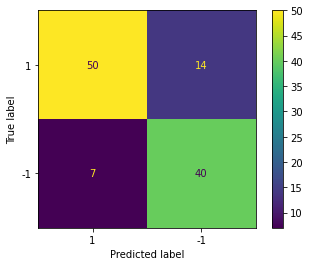

In [37]:
def calculate_confusion_matrix(*, y, y_pred) -> np.ndarray:
    # @student: calculate the confusion matrix
    # hint: you can use np.logical_and()

    TP = np.sum(np.logical_and(y_pred==1, y==1))
    FP = np.sum(np.logical_and(y_pred==-1, y==1))
    TN = np.sum(np.logical_and(y_pred==1, y==-1))
    FN = np.sum(np.logical_and(y_pred==-1, y==-1))

    return np.array([[TP, TN], [FP, FN]])


cm = calculate_confusion_matrix(y=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["1", "-1"])
disp.plot()
plt.show()